In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import networkx as nx

import dhg
from dhg import Graph
from dhg import Hypergraph
from dhg.data import Cora
from dhg.data import CoauthorshipCora
from dhg.data import CocitationCora
from dhg.data import YelpRestaurant
from dhg.data import Yelp3k
from dhg.data import IMDB4k
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

c:\Users\lolis\Documents\UNI\Kurser\master thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data

## Coauthorship Cora

In [21]:
dataset = CoauthorshipCora()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [22]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
print("Edge index:", dataset['edge_list'])

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Data object: This is coauthorship_cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Edge index: [(235, 355), (1133, 1666, 1888), (783, 785), (570, 1058, 1211, 1246), (523, 717), (543, 603, 1163, 1355), (52, 140, 251, 323, 535, 865, 932, 1024, 1505, 1823, 2476, 2487, 2555, 2560, 2580), (1580, 2329), (701, 1019, 1659, 1869), (62, 270, 339, 495, 573, 723, 773, 1137, 1983, 2078, 2406, 2425, 2474, 2566), (269, 2415, 2438, 2530), (19, 424, 571, 1762, 2331, 2495, 2694), (487, 538, 1822, 2281), (877, 1010, 1578, 1651), (40, 114, 171, 488, 761, 798, 1124, 1390, 1566, 1567, 1661, 1888, 2053, 2054), (52, 701, 1019, 1539), (1538, 1724), (52, 2487, 2555), (141, 1184, 1959), (681, 1391, 2437), (1325, 2047), (476, 1787, 1871, 2385, 2676), (357, 803, 1

## Cocitation Cora

In [3]:
dataset = CocitationCora()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [4]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
print("Edge index:", dataset['edge_list'])

# Print the node features
print("Node features:", dataset['features'].shape)

# Print the labels
print("Labels:", dataset['labels'].shape)

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Data object: This is cocitation_cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Edge index: [(163, 219, 538), (163, 1114), (163, 427, 881, 2667), (163, 343, 427, 1303, 1305), (163, 1136), (163, 566, 1206), (163, 523, 1409, 2220), (129, 163, 1719, 1969, 2165), (55, 163, 1834), (100, 163, 1153, 1379, 1380), (163, 188, 1184), (163, 2490), (163, 793, 1016, 1728, 1729), (163, 501, 503, 2409), (145, 163, 2164, 2529), (163, 430, 582, 2067), (163, 1153), (163, 793, 1130, 1696), (163, 1523), (163, 727, 1424, 2205), (163, 1696, 1936), (163, 743, 744, 2030), (163, 764), (163, 846, 1184, 1533), (163, 934), (163, 1153), (163, 910, 965), (163, 793, 1249, 1592, 1715), (163, 1257, 1696, 1771), (145, 163, 2280), (145, 163), (163, 941, 1380, 1441), (16

## Yelp Restaurant

In [3]:
dataset = Yelp3k()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [4]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 6
Number of nodes: 3855
Number of node features: 1862
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


## IMDB

In [9]:
dataset = IMDB4k()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_by_director']).to(device)

In [10]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 3
Number of nodes: 4278
Number of node features: 3066
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


# Models

## HCoGNN

In [23]:
from HCoGNN import HCoGNN_node_classifier

def random_walk_matrix(G):
    deg = G.deg_v
    v2e_weight = torch.ones_like(G.v2e_weight, dtype=torch.float32)
    e2v_weight = torch.ones_like(G.e2v_weight, dtype=torch.float32)
    for i, v in enumerate(G.v2e_src):
        v2e_weight[i] = 1.0 / deg[v]
    return v2e_weight, e2v_weight

model = HCoGNN_node_classifier(num_node_features, num_classes, G, 'sum', 'sum', 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#edge_weight = random_walk_matrix(G)
edge_weight = (None,None)
model.to(device)

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", X.device)

Model: HCoGNN_node_classifier(
  (classifier): Linear(in_features=3066, out_features=3, bias=True)
  (action_net): action_network(
    (lin_update): Linear(in_features=3066, out_features=4, bias=True)
    (conv): HGNNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=3066, out_features=4, bias=False)
    )
  )
  (environment_net): environment_network(
    (lin_message): Linear(in_features=3066, out_features=3066, bias=False)
    (lin_update): Linear(in_features=3066, out_features=3066, bias=True)
    (conv): HGNNConv(
      (act): ReLU(inplace=True)
      (drop): Dropout(p=0.5, inplace=False)
      (theta): Linear(in_features=3066, out_features=3066, bias=False)
    )
  )
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Model Device: cuda:

# Training

In [24]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(X, edge_weight)
    #loss = F.nll_loss(out[train_mask], labels[train_mask])
    loss = F.cross_entropy(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities

        # Train accuracy
        train_logits = logits[train_mask] # Log probabilities of train nodes
        train_labels = labels[train_mask] # True labels of train nodes
        train_pred = train_logits.max(1)[1] # Predicted labels
        train_correct = train_pred.eq(train_labels).sum().item() # Number of correctly classified nodes
        train_accuracy = train_correct / train_mask.sum().item() # Accuracy

        # Validation accuracy
        val_logits = logits[val_mask] # Log probabilities of validation nodes
        val_labels = labels[val_mask] # True labels of validation nodes
        val_pred = val_logits.max(1)[1] # Predicted labels
        val_correct = val_pred.eq(val_labels).sum().item() # Number of correctly classified nodes
        val_accuracy = val_correct / val_mask.sum().item() # Accuracy
            
    return train_accuracy, val_accuracy

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels
        correct = pred.eq(test_labels).sum().item() # Number of correctly classified nodes
        accuracy = correct / test_mask.sum().item() # Accuracy

        for layer in range(model.num_iterations):
            actions = model.action_history[layer].cpu()

            # Convert list to numpy array
            actions_array = np.array(actions)

            # Compute the ratio
            ratio = np.bincount(actions_array) / len(actions_array)

            print(f"Ratio of actions in layer {layer}: {ratio}")
                        
    return accuracy, pred

from sklearn.metrics import confusion_matrix

def visualize_results():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels

        cm = confusion_matrix(test_labels.cpu(), pred.cpu())

        # Normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fig, ax = plt.subplots(1, 2, figsize=(20,10))

        # Plot confusion matrix
        im = ax[0].matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar(im, ax=ax[0])
        ax[0].set_title('Confusion matrix')
        ax[0].set_ylabel('True label')
        ax[0].set_xlabel('Predicted label')

        plt.show()

In [25]:
# Run the training
for epoch in range(1000):
    loss = train()

    if epoch % 100 == 0:
        train_accuracy, val_accuracy = validate()
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1, Loss: 1.0986
Training Accuracy: 0.3843, Validation Accuracy: 0.1703
Epoch 101, Loss: 0.7717
Training Accuracy: 0.8672, Validation Accuracy: 0.5454
Epoch 201, Loss: 0.5737
Training Accuracy: 0.9860, Validation Accuracy: 0.6286
Epoch 301, Loss: 0.5645
Training Accuracy: 0.9883, Validation Accuracy: 0.6165
Epoch 401, Loss: 0.5624
Training Accuracy: 0.9892, Validation Accuracy: 0.6211
Epoch 501, Loss: 0.5617
Training Accuracy: 0.9897, Validation Accuracy: 0.6099
Epoch 601, Loss: 0.5615
Training Accuracy: 0.9906, Validation Accuracy: 0.6127
Epoch 701, Loss: 0.5615
Training Accuracy: 0.9897, Validation Accuracy: 0.6146
Epoch 801, Loss: 0.5614
Training Accuracy: 0.9902, Validation Accuracy: 0.6165
Epoch 901, Loss: 0.5613
Training Accuracy: 0.9902, Validation Accuracy: 0.6165


Ratio of actions in layer 0: [1.]
Ratio of actions in layer 1: [0.25923329 0.23749416 0.24707807 0.25619448]
Test Accuracy: 0.5561, Training Accuracy: 0.9897, Validation Accuracy: 0.6127


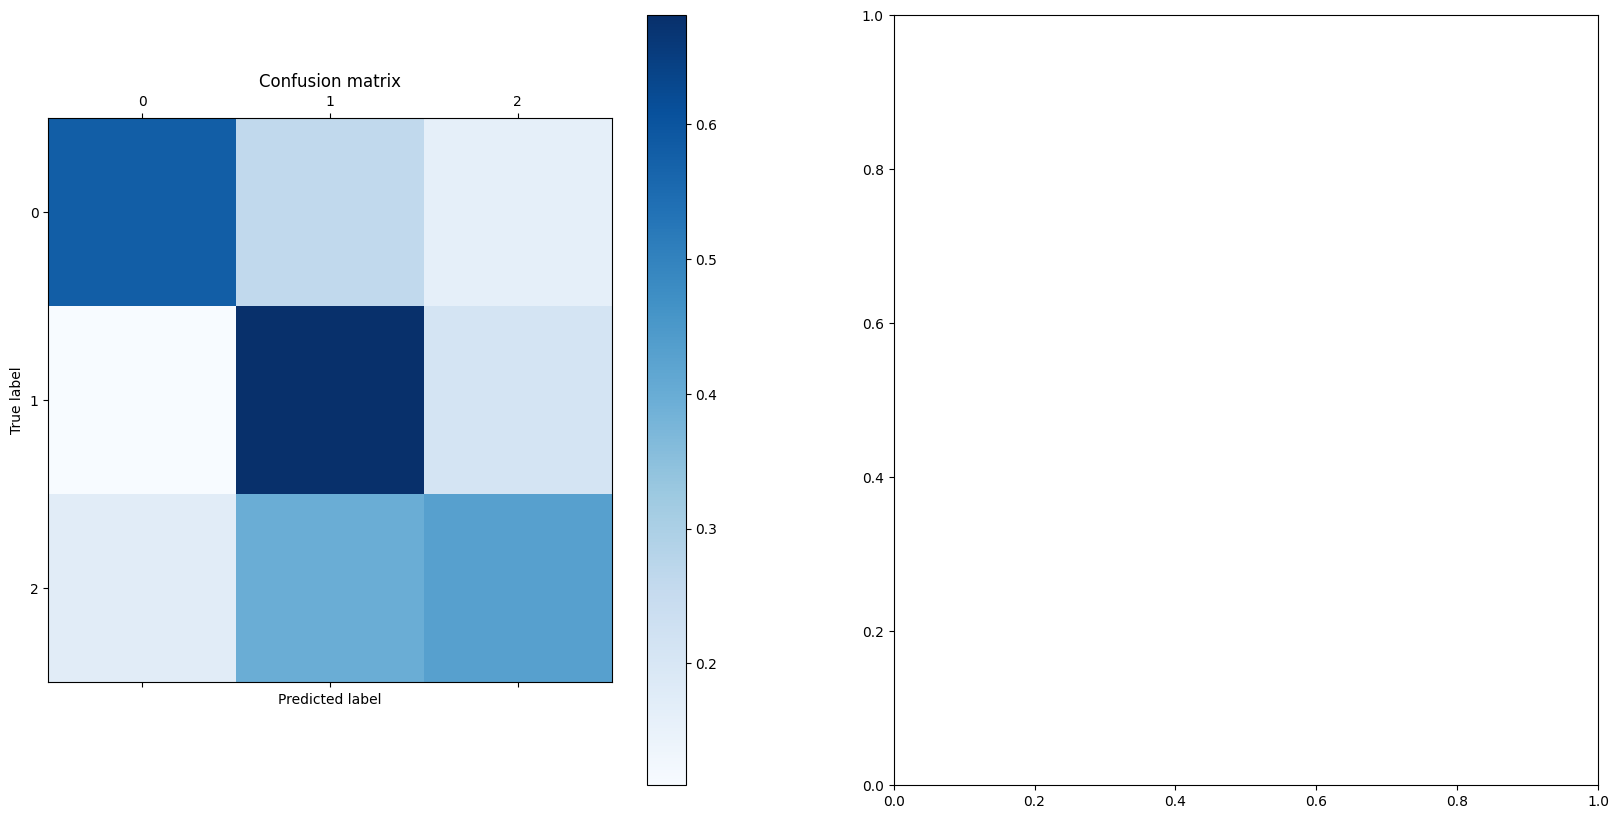

In [26]:
# Test the model
train_accuracy, val_accuracy = validate()
accuracy, predictions = test()
print(f'Test Accuracy: {accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

visualize_results()